# Data Analysis on Pikes Peak 10k Race Results

The following notebook imports race results from the Pikes Peak 10k run in 2024. The results can be extracted from the [official race website](https://www.pikespeek10k.org/) with the official results [here](https://mcrrc.org/race-result/pikes-peek-10k-17/). We will conduct exploratory data analysis, data engineering, and produce data visualizations to generate understandings and conclusions about the race results. We aim to first answer questions surrounding the characteristics of the runners' times. We also will investigate the differences between columns and what kind of information the differences convey-for example, the difference between the net time and the gun time. We also will hone in on a specific runner and compare that runner's results with runners in his division and conduct comparisons between divisions in general.

In [1]:
import datetime
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statistics
import random
import re
pd.options.mode.chained_assignment = None


# Data Preparation and Exploration
### Initial data exploration
Read in data and investigate shapes/types. We see columns that I would expect to be a time are objects instead, (like `Net Time` and `Gun Time`) which is an important detail as we proceed. We need to make sure our columns match the data type that makes the most sense in order to produce reliable analytics.

In [2]:
# Needed to read in the male file with the encoding iso-8859-1 because it was not in uint8
df = pd.read_csv('Pikes_Peak_10k_Results.txt', delimiter = "\t", encoding="iso-8859-1")

print("Pikes_Peak_10k_Results.txt is type: ", type(df))


Pikes_Peak_10k_Results.txt is type:  <class 'pandas.core.frame.DataFrame'>


Lets check the type of the columns for each dataset

In [3]:
print(df.dtypes)
df.head()

Place        int64
Gen/Tot     object
Div/Tot     object
Num          int64
Name        object
Gender      object
Age          int64
Hometown    object
Gun Time    object
Net Time    object
Pace        object
dtype: object


,Place,Gen/Tot,Div/Tot,Num,Name,Gender,Age,Hometown,Gun Time,Net Time,Pace
0,1,1/785,1/63,28,Neil Saddler,M,27,Washington DC,30:27,30:26,4:54
1,2,2/785,1/28,29,Jack Whetstone,M,24,Washington DC,30:34,30:34,4:56
2,3,3/785,1/89,1862,Max McNeill,M,30,Arlington VA,30:39,30:39,4:56
3,4,4/785,1/102,31,Zach Pistilli,M,35,Chantilly VA,30:51,30:51,4:58
4,5,5/785,2/102,38,Ashenafi Birhana,M,35,Washington DC,31:14,31:13,5:02


### Clean `Gun Time` and `Net Time`

We want to get rid of trailing and leading items that are not numbers. We will leverage regular expressions to do so. The following list details the regular expressions used to clean the data

*   r   : raw literal string
*   ^   : regular expression for start of string
*   \D+ : Any non digit. The plus sign denotes one or more occurances of the digit
*   |   : or operator
*   $   : matches the end of the string



In [4]:
df['GunTime'] = df['Gun Time'].str.replace(r'^\D+|\D+$', '', regex=True)
df['NetTime'] = df['Net Time'].str.replace(r'^\D+|\D+$', '', regex=True)

We have the columns that represent times in a format that looks like a time (`HH:MM:SS`) but we need to convert these columns to a datetime data type so those columns are treated as time variables.

In [5]:
def convert_to_time(time_str):
  '''
  Function to convert column from object to datetime.

  Parameters:
    time_st: The time string to be converted. Expected to be in "MM:SS" or
             "HH:MM:SS" format.

    Returns:
    datetime.time: A time object representing the input time string. Returns
                   None if the input string does not match the expected formats.
  '''

  time_str_split = time_str.split(":")

  if len(time_str_split)==2:

    return pd.to_datetime(time_str, format = "%M:%S").time()

  elif len(time_str_split)==3:
    return pd.to_datetime(time_str, format = "%H:%M:%S").time()

  else:
    return None


def time_to_seconds(t):
  '''
  Convert date time from "HH:MM:SS" to "Seconds"

  Parameters:
      t: Date time in the format of "HH:MM:SS"

  Returns:
      time in seconds.
  '''
  return t.hour * 3600 + t.minute * 60 + t.second

def seconds_to_time(total_seconds):
  '''
  Converts object from seconds back to "HH:MM:SS" format.

  Parameters:
      total_seconds: Time in the format of seconds.

  Returns:
      time_h_m_s: Datetime in the format of "HH:MM:SS".
  '''
  if total_seconds < 0:
      total_seconds = 0
  # Use // for floor functionality
  hours = total_seconds // 3600
  minutes = (total_seconds % 3600) // 60
  seconds = total_seconds % 60
  time_h_m_s = datetime.time(hour=int(hours), minute=int(minutes), second=int(seconds)).strftime('%H:%M:%S')
  return time_h_m_s


Create a new column to convert `Net Time` and `Gun Time` to `datetime` type.

In [6]:
df["NetTime_Final"] = df["NetTime"].apply(convert_to_time)
df["GunTime_Final"] = df["GunTime"].apply(convert_to_time)

Create a new column to convert the data from `HH:MM:SS` format to `seconds`.

In [7]:
df["NetTime_Seconds"] = df["NetTime_Final"].apply(lambda t: time_to_seconds(t) if t is not None else None)
df["GunTime_Seconds"] = df["GunTime_Final"].apply(lambda t: time_to_seconds(t) if t is not None else None)

We can see that the `Net Time` and the `Gun Time` provide very similar results. This makes sense because the net time versus gun time recorded for each individual should not be that different, as the race officials typically start the race waves soon after one another. For example, the fastest heat is in the front, towards the starting line. The race officials start the race for each progressively slower heat one after another, with only a couple minutes in between the starts.


*   The `gun time` for individuals records the time since the official race starts (when the gun is flared) and stops when the runner crosses the finish line.
*   The `net time` starts the time for the runner once their bib is registered as passing the starting line and stops when that bib crosses the finish line.


We see that the minimum values match between the Net and Gun time but there is a larger difference between the max times for both groups (about 200 seconds). The mean and median gun times were higher than the net times. I would assume that the range between `gun time` and `net time` is smaller for faster individuals, because the faster heats always start the race. Then the slower racers begin further in the back and have a delayed start because of traffic at the start of the race.

### Summary Statistics and Comparison by Net Time and Gun Time
Now that the data has been cleaned, we can proceed to obtain summary statistics, including the minimum, maximum, range, mean, and median values. These summary statistics are crucial for validating the dataset and enhancing our understanding of its underlying patterns and characteristics.

In [8]:
summary_stats = df.groupby("Gender").agg({
    "NetTime_Seconds":['min', 'max', 'mean', 'median'],
    "GunTime_Seconds":['min', 'max', 'mean', 'median']
    })

display(summary_stats)

summary_stats['NetTime_Seconds', 'range'] = summary_stats['NetTime_Seconds','max'] - summary_stats['NetTime_Seconds','min']
summary_stats['GunTime_Seconds', 'range'] = summary_stats['GunTime_Seconds','max'] - summary_stats['GunTime_Seconds','min']



NetTime_Seconds                            GunTime_Seconds        \
                   min   max         mean  median             min   max   
Gender                                                                    
F                 2038  6701  3951.919204  3873.5            2039  6844   
M                 1826  6780  3377.266242  3286.0            1827  6824   
X                 2456  3494  2975.000000  2975.0            2460  3556   

                             
               mean  median  
Gender                       
F       4009.819672  3927.0  
M       3416.284076  3328.0  
X       3008.000000  3008.0

We will now convert the summary statistics back to the the `hour:minute:second` format. We will also only use the `Gun Time` because that is what is used to judge the official results. Main takeaways are:


*   The minimum value is about 1 second slower for women when comparing `Net Time` versus `Gun Time`, so the fastest woman runner had a very accurate time, given the negligable difference between Net and Gun times.
*   The maximum value is about 2.3 minutes slower for women when comparing `Net Time` versus `Gun Time`
*   The mean `Net Time` is faster for both Men, Women and X divisions as compared to the `Gun Time`
*   The winning male won passed the finish line ~3.5 minutes before the first female
*   The median times for all divisions are faster than the mean time, as the mean notoriously is sensitive to outliers

### Final Summary Statistics

In [9]:
summary_stats['GunTime_Seconds', 'min'] = summary_stats['GunTime_Seconds', 'min'].apply(seconds_to_time)
summary_stats['GunTime_Seconds', 'max'] = summary_stats['GunTime_Seconds', 'max'].apply(seconds_to_time)
summary_stats['GunTime_Seconds', 'mean'] = summary_stats['GunTime_Seconds', 'mean'].apply(seconds_to_time)
summary_stats['GunTime_Seconds', 'median'] = summary_stats['GunTime_Seconds', 'median'].apply(seconds_to_time)
summary_stats['GunTime_Seconds', 'range'] = summary_stats['GunTime_Seconds', 'range'].apply(seconds_to_time)



summary_stats_seconds = summary_stats['GunTime_Seconds'][['min', 'max', 'mean', 'median', 'range']]
summary_stats_seconds

,min,max,mean,median,range
Gender,,,,,
F,00:33:59,01:54:04,01:06:49,01:05:27,01:20:05
M,00:30:27,01:53:44,00:56:56,00:55:28,01:23:17
X,00:41:00,00:59:16,00:50:08,00:50:08,00:18:16


Below is a pie chart that represents the percent of runners that were in the Male, Female and Unspecifed Gener races

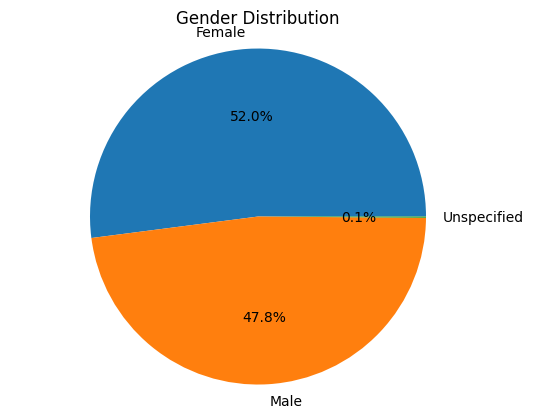

In [10]:
# get counts
gender_counts = df.groupby(['Gender']).size().reset_index(name="count")

# create labels and get counts
labels = gender_counts['Gender'].map({'F': 'Female', 'M': 'Male', 'X': 'Unspecified'})
sizes = gender_counts['count']

# Create the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Gender Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


### Net Time Visualizations
We will use the power of boxplots to visualize these summary statistics in a plot. We can visually see the larger range of race time values for women as compared to men and also see that all quantile values are slower for women than men. These results match Strava's* [findings](https://www.verywellfit.com/how-long-will-it-take-to-run-a-10k-2911115#:~:text=According%20to%20data%20compiled%20by,%3A03%3A17%20to%20finish.), where they found the average woman runs a 10k in 1:03:17 and the average male runs a 10k in 55:37. Pikes Peak's race results are negligably slower than these average times (2 to 3 minutes), which would make sense given the difficulty of running at an altitude.

\* Strava is a poplar smartphone application to track one's running pace


<ipython-input-11-27bd284333ba>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  boxplot.set_yticklabels([seconds_to_time(int(tick.get_text())) for tick in boxplot.get_yticklabels()])


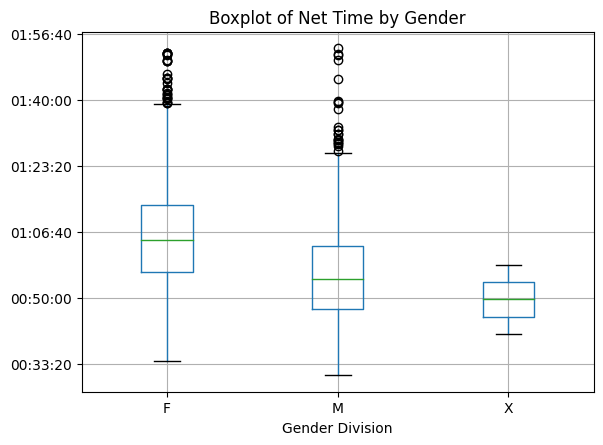

In [11]:
# create boxplot
boxplot=df.boxplot(column='NetTime_Seconds', by='Gender')

# change boxplot y ticks
boxplot.set_yticklabels([seconds_to_time(int(tick.get_text())) for tick in boxplot.get_yticklabels()])

# change boxplot title
boxplot.set_title('Boxplot of Net Time by Gender')

# x axis title
boxplot.set_xlabel('Gender Division')
plt.suptitle("")
plt.show()

### Find Net Time Mode for Each Division
Following we will obtain the mode race values for the Female and Male division.

In [12]:
# Consider the data by gender and then group by racetime to find the mode time.
net_time_count_df_F = df[df["Gender"]=="F"].groupby(['NetTime_Seconds']).size().reset_index(name = "count").sort_values("count", ascending = False)

# mode race time value for females
mode_value_F = net_time_count_df_F['count'].iloc[0]

# subset the female race results to get the race times that occured the amount of times equal to the mode
mode_times_df_F = net_time_count_df_F[net_time_count_df_F['count']== mode_value_F]

# Change the data back to HH:MM:SS format
mode_times_df_F['NetTime_Seconds'] = mode_times_df_F['NetTime_Seconds'].apply(seconds_to_time)

mode_times_df_F



,NetTime_Seconds,count
265,01:00:02,4
240,00:58:39,4
487,01:11:14,4


Apply the same logic to find the mode for males

In [13]:
# Consider the data by gender and then group by racetime to find the mode time.
net_time_count_df_M = df[df["Gender"]=="M"].groupby(['NetTime_Seconds']).size().reset_index(name = "count").sort_values("count", ascending = False)

# mode race time value for males
mode_value = net_time_count_df_M['count'].iloc[0]

# subset the male race results to get the race times that occured the amount of times equal to the mode
mode_times_df_M = net_time_count_df_M[net_time_count_df_M['count']== mode_value]

# Change the data back to HH:MM:SS format
mode_times_df_M['NetTime_Seconds'] = mode_times_df_M['NetTime_Seconds'].apply(seconds_to_time)

mode_times_df_M

,NetTime_Seconds,count
379,00:56:56,4


The mode times for the females averaged out to be about the mean time for Female runners. The one mode for Male runners is 1 minute away from the mean time for Males. I did not get the mode for the X category given the small division size.

### Analyze the difference between gun and nettime race results.

As previously mentioned, `Gun Time` generally produces values that are larger than the `Net Time`. Slower runners have a larger difference between the net and bib time, as compared to the faster runners. Lets investigate how different the values are through data visualization. We will plot the data on a scatter plot, `Gun Time` versus the `difference between Gun Time and Net Time`. We will fit a linear regression to the data to represent the slope.



<ipython-input-14-8e0f987042e6>:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df[df['GunTime_Binned'] == time_bin]['GunTime_Seconds'],
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


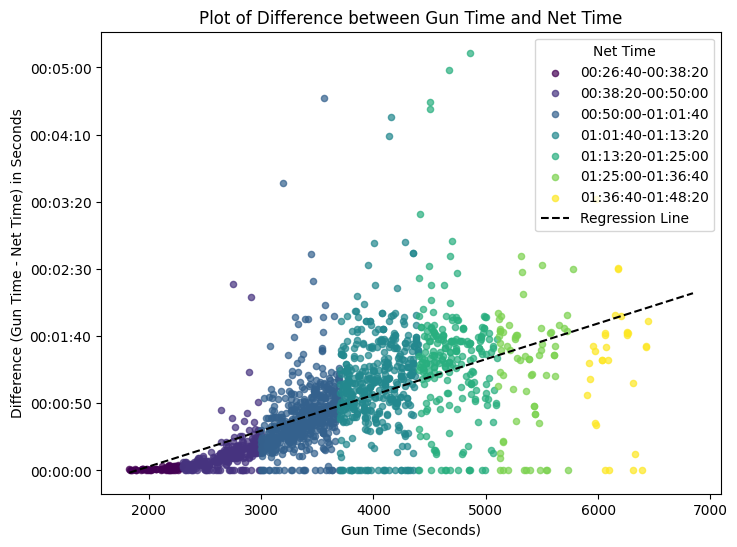

In [14]:
# create bins
bins = [1600, 2300, 3000, 3700, 4400, 5100, 5800, 6500]

# create bin labels
labels = [(seconds_to_time(bins[x]) + "-" + seconds_to_time(bins[x+1])) for x in range(len(bins)-1)]

# Create a new column for binned values (GunTime_Seconds)
df['GunTime_Binned'] = pd.cut(df['GunTime_Seconds'], bins=bins, labels=labels, right=False)

bin_avg_net_time = df.groupby('GunTime_Binned')['NetTime_Seconds'].mean().reset_index()

# Normalize values for colormap
norm = plt.Normalize(bin_avg_net_time['NetTime_Seconds'].min(), bin_avg_net_time['NetTime_Seconds'].max())
colors_map = cm.viridis(norm(bin_avg_net_time['NetTime_Seconds']))

# Set a color dictionary
colors = {label: color for label, color in zip(labels, colors_map)}


# Difference between times
difference =  df['GunTime_Seconds']-df["NetTime_Seconds"]

# Create scatter plot
plt.figure(figsize=(8, 6))
for time_bin, color in colors.items():

  plt.scatter(df[df['GunTime_Binned'] == time_bin]['GunTime_Seconds'],
                difference[df['GunTime_Binned'] == time_bin],
                c=color, label=time_bin, s=20, alpha=0.7)

plt.yticks(plt.gca().get_yticks(), [seconds_to_time(int(tick)) for tick in plt.gca().get_yticks()])

# Fit linear regression from sklear.linear_model
model = LinearRegression()
model.fit(df[['GunTime_Seconds']], difference)

# Predict values using the model
x_values = np.linspace(df['GunTime_Seconds'].min(), df['GunTime_Seconds'].max(), 100)
y_values = model.predict(x_values[:, np.newaxis])

# Plot regression line
plt.plot(x_values, y_values, color='black', linestyle='--', label='Regression Line')

# Set labels
plt.xlabel('Gun Time (Seconds)')
plt.ylabel('Difference (Gun Time - Net Time) in Seconds')
plt.title('Plot of Difference between Gun Time and Net Time')
plt.legend(title='Net Time')
plt.show()

We see that the data fans out as the recorded race times get slower. The regression line that was fit to the data shows a positive relationship between `gun_time` and the difference between `gun_time` and `net_time`. We see that in every division, there were some runners that had no difference between their Net and Gun times, which could suggest that some people could have cut to the front at the starting line.


We will now create a bar plot to show the average difference between `gun time` and `net time` for binned gun times.

In [15]:
# Group by the binned GunTime_Seconds and calculate the mean difference
mean_diff = df.groupby('GunTime_Binned').apply(lambda x: (x['GunTime_Seconds'] - x['NetTime_Seconds']).mean())
count = df.groupby('GunTime_Binned').size()

# Combine the results into a DataFrame
mean_diff_df = pd.DataFrame({'Mean Difference': mean_diff, 'Count': count})

mean_diff_df.insert(1, 'Binned Gun Time (Seconds)', [(str(bins[x]) + "-" + str(bins[x+1])) for x in range(len(bins)-1)])

# Display output
mean_diff_df = mean_diff_df.reset_index()
mean_diff_df.columns = ['GunTime_Binned', 'Mean_Difference', 'Binned Gun Time (Seconds)', 'Count']

mean_diff_df = mean_diff_df.rename(columns = {"GunTime_Binned": "Binned Gun Time", "Mean_Difference": "Mean Difference from Net Time"})
mean_diff_df

,Binned Gun Time,Mean Difference from Net Time,Binned Gun Time (Seconds),Count
0,00:26:40-00:38:20,1.296875,1600-2300,64
1,00:38:20-00:50:00,12.455224,2300-3000,268
2,00:50:00-01:01:40,39.130996,3000-3700,542
3,01:01:40-01:13:20,65.380510,3700-4400,431
4,01:13:20-01:25:00,82.121622,4400-5100,222
5,01:25:00-01:36:40,73.956522,5100-5800,69
6,01:36:40-01:48:20,81.000000,5800-6500,31


<ipython-input-16-27f61d605602>:12: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


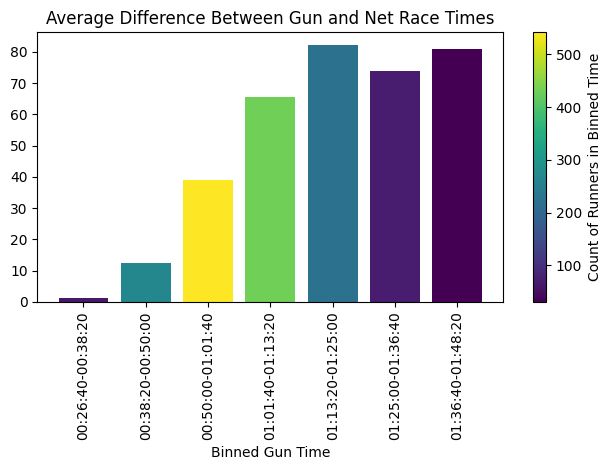

In [16]:
# Normalize values for colormap
norm = plt.Normalize(mean_diff_df['Count'].min(), mean_diff_df['Count'].max())
colors_map = cm.viridis(norm(mean_diff_df['Count']))

plt.bar(mean_diff_df['Binned Gun Time (Seconds)'], mean_diff_df['Mean Difference from Net Time'], color = colors_map)
plt.title("Average Difference Between Gun and Net Race Times")
plt.xlabel("Binned Gun Time")
plt.xticks(mean_diff_df['Binned Gun Time (Seconds)'], mean_diff_df['Binned Gun Time'], rotation = 90)

sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Count of Runners in Binned Time')

plt.tight_layout()
plt.show()



The Scatter Plot illustrates a clear positive relationship between `Gun Time` and the difference between `Gun Time` and `Net Time`. Similarly, this positive trend is evident in the bar chart, where increasing `Gun Time` values correspond to greater delays between `Gun` and `Net Time`. Notably, the slowest binned values show a slight decrease in this difference. There was less time between when the gun flared at the start of the race and when those slower runners finished than the difference between when the gun flared and when slightly faster runners finished. Maybe some runners got a head start, which is why we use net time versus gun time. But  we also see that the fastest bin and slowest bin times have less runners ~100 people which might make the difference between `Gun Time` and `Net Time` sensitive to outliers. We had the most runners finish between 50 and 61 minutes.

# Lets investigate the amount of time that separates a random person from the top 15 percentile of racers of the same division?

In [17]:
# define the bin edges (The oldest runner was 84)
bins = [0, 14, 19, 29, 39, 49, 59, 69, 79, 89]
divisions = ['0-14', '15-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89']

# bin the age column
df['Division'] = pd.cut(df['Age'], bins, labels = divisions)

random_person = random.randint(0, len(df))
random_person_name = df.iloc[random_person]['Name']

# Retrieve random person's net time and Division
random_person_time = df[df['Name']==random_person_name]['NetTime_Seconds'].values[0]
random_person_div = df[df['Name']==random_person_name]['Division'].iloc[0]
random_person_gender = "Male" if df.iloc[random_person]['Gender'] == "M" else "Female"

print(f"{random_person_name} is in the {random_person_gender} division {random_person_div}. {random_person_name}'s time was {seconds_to_time(random_person_time)} ({random_person_time} in seconds)")

top_15_percentile_person = df[(df['Gender']=="M")&(df['Division']==random_person_div)]['GunTime_Seconds'].quantile(0.15)
print(f"The time for the top 15th percentile of racers in the division {random_person_div} is {seconds_to_time(top_15_percentile_person)} ({top_15_percentile_person} in seconds)")
print(f'{top_15_percentile_person-random_person_time} seconds separate {random_person_name} from the top 15th percentile of racers in the same division')

if (top_15_percentile_person-random_person_time)<0:
  print(f'{random_person_name} was {seconds_to_time(abs(top_15_percentile_person-random_person_time))} behind the top 15th percentile of runners in their division')
else:
    print(f'{random_person_name} was {seconds_to_time(abs(top_15_percentile_person-random_person_time))} ahead the top 15th percentile of runners in their division')


Livya Heithaus is in the Female division 40-49. Livya Heithaus's time was 01:11:23 (4283 in seconds)
The time for the top 15th percentile of racers in the division 40-49 is 00:42:01 (2521.7 in seconds)
-1761.3000000000002 seconds separate Livya Heithaus from the top 15th percentile of racers in the same division
Livya Heithaus was 00:29:21 behind the top 15th percentile of runners in their division


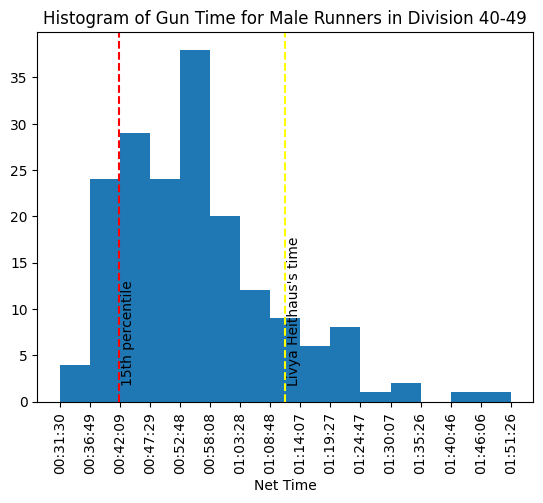

In [18]:
n, bins, patches = plt.hist(df[(df['Gender']=="M")&(df['Division']==random_person_div)]['GunTime_Seconds'], bins = 15)
plt.axvline(top_15_percentile_person, color='red', linestyle='--')
plt.text(top_15_percentile_person+20,2,'15th percentile',rotation=90)
plt.axvline(random_person_time, color='yellow', linestyle='--')
plt.text(random_person_time+20,2,f'{random_person_name}\'s time',rotation=90)
plt.xlabel("Net Time")
plt.title('Histogram of Gun Time for Male Runners in Division ' + random_person_div)
plt.xticks(ticks = bins, labels = [seconds_to_time(x) for x in bins], rotation = 90)

plt.show()

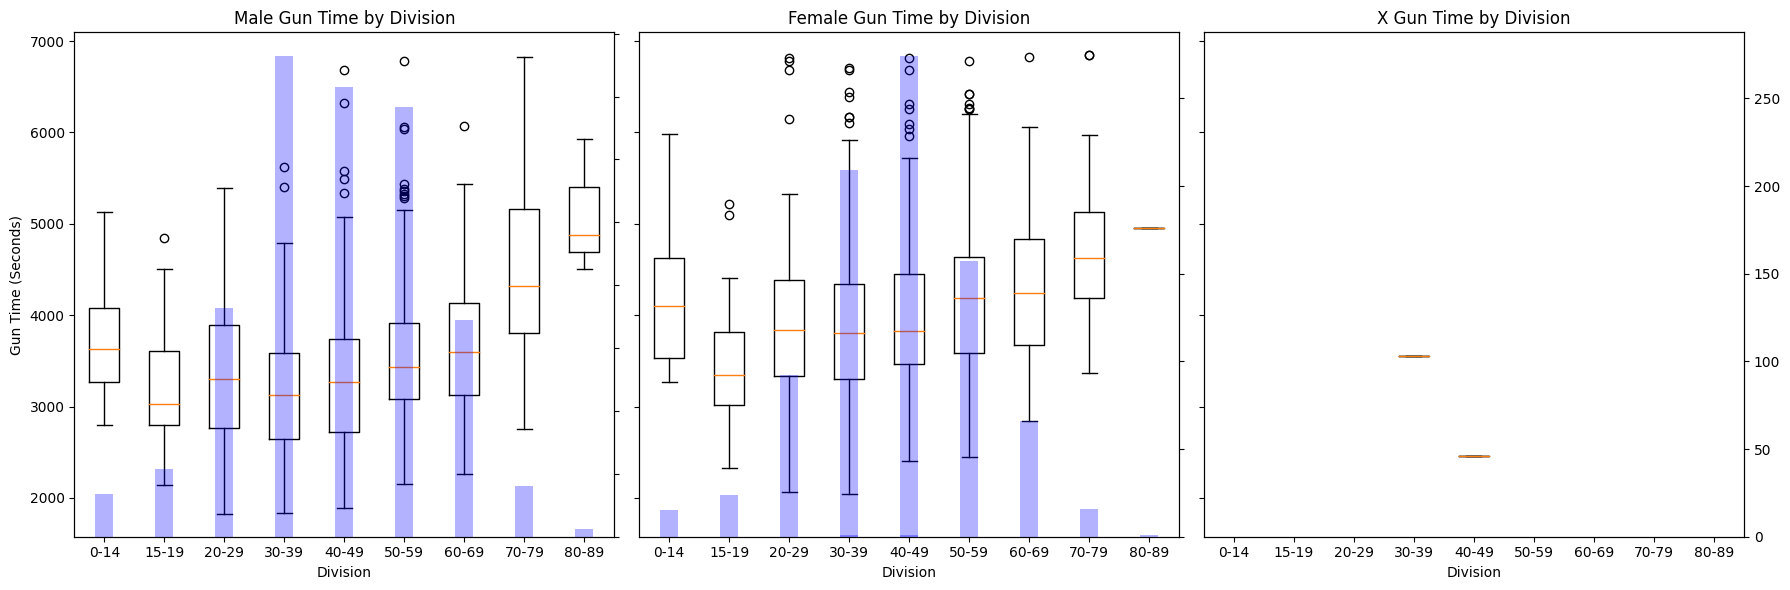

In [19]:
# separate male and female
male_df = df[df['Gender'] == 'M']
female_df = df[df['Gender'] == 'F']
x_df = df[df['Gender'] == 'X']

# Boxplot data
# Need this line to uphold order of divisions
df['Division'] = pd.Categorical(df['Division'], categories=divisions, ordered=True)
data_male = [male_df[male_df['Division'] == div]['GunTime_Seconds'] for div in divisions]
data_female = [female_df[female_df['Division'] == div]['GunTime_Seconds'] for div in divisions]
data_x = [x_df[x_df['Division'] == div]['GunTime_Seconds'] for div in divisions]

# get counts for histogram
counts_male = [len(male_df[male_df['Division'] == div]) for div in divisions]
counts_female = [len(female_df[female_df['Division'] == div]) for div in divisions]
counts_x = [len(x_df[x_df['Division'] == div]) for div in divisions]

fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Male box plot
ax[0].boxplot(data_male, labels=divisions)
ax[0].set_title('Male Gun Time by Division')
ax[0].set_xlabel('Division')
ax[0].set_ylabel('Gun Time (Seconds)')
ax2 = ax[0].twinx()

bars1 = ax2.bar(range(1, len(divisions)+1 ), counts_male, width=0.3, alpha=0.3, color='blue', align='center')
ax2.set_yticklabels("")


# Female box plot
ax[1].boxplot(data_female, labels=divisions)
ax[1].set_title('Female Gun Time by Division')
ax[1].set_xlabel('Division')
ax2 = ax[1].twinx()
ax2.set_yticklabels("")
bars2 = ax2.bar(range(1, len(divisions)+1 ), counts_female, width=0.3, alpha=0.3, color='blue', align='center')

# X box plot
ax[2].boxplot(data_x, labels=divisions)
ax[2].set_title('X Gun Time by Division')
ax[2].set_xlabel('Division')
ax3 = ax[2].twinx()

bars3 = ax2.bar(range(1, len(divisions)+1 ), counts_x, width=0.3, alpha=0.3, color='blue', align='center')
ax3.set_ylim(ax2.get_ylim())

plt.tight_layout()
plt.show()


*   The three age groups 20-29, 30-39 and 40-49 seem to have the same medians for the male division. Similarly, those same divisions in the female race have about the same median values as well.
*   The male divisions had faster median values for all divisions
*   The popularity of the race was different between males and females. The division 30-39 was the most popular for males, followed by 40-49 then 50-59. The most popular age divisions for females was 40-49 then 30-39, then 50-59. The same three divisions had the most participants between males and females, but in different orders
*   There were not many runners in the X division. There was 1 individual who was in the 30-39 group and one in the 40-49 group


# We will investigate the times for each division

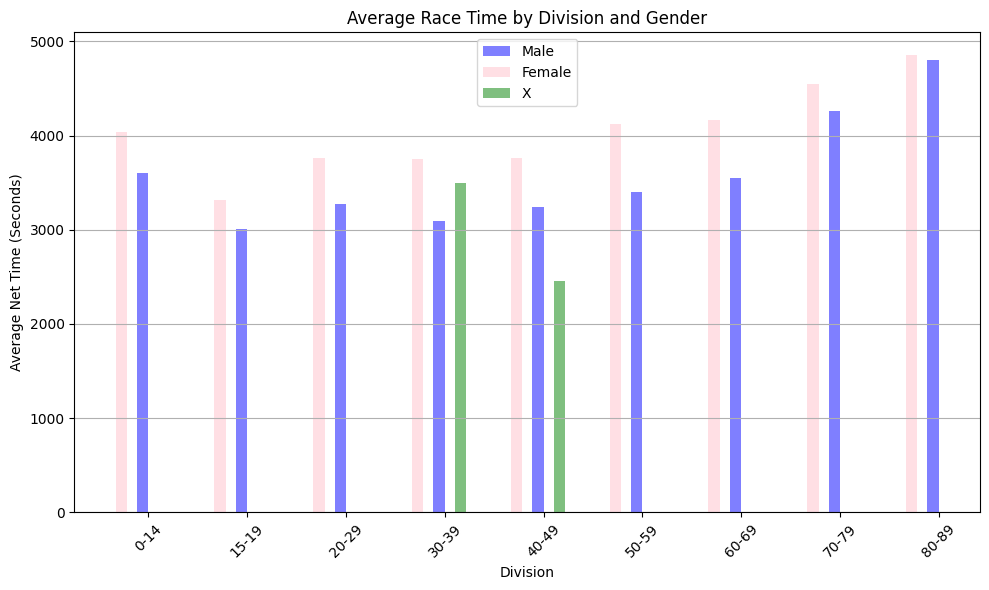

In [20]:
# Calculate average race time by division and gender
avg_race_time = df.groupby(['Division', 'Gender'])['NetTime_Seconds'].median().reset_index()

# Separate data for males and females
avg_race_time_male = avg_race_time[avg_race_time['Gender'] == 'M']
avg_race_time_female = avg_race_time[avg_race_time['Gender'] == 'F']
avg_race_time_x = avg_race_time[avg_race_time['Gender'] == 'X']

# Plotting
plt.figure(figsize=(10, 6))

# Set the width of the bars
bar_width = 0.35

# Plot bars for males
plt.bar(avg_race_time_male.index, avg_race_time_male['NetTime_Seconds'], width=bar_width, color='blue', alpha=0.5, label='Male')

# Plot bars for females next to males
plt.bar(avg_race_time_female.index + bar_width, avg_race_time_female['NetTime_Seconds'], width=bar_width, color='pink', alpha=0.5, label='Female')

# Plot bars for x next to femals
plt.bar(avg_race_time_x.index + bar_width- .7, avg_race_time_x['NetTime_Seconds'], width=bar_width, color='green', alpha=0.5, label='X')

# Set x-axis ticks and labels
plt.xticks(avg_race_time_male.index + bar_width / 2, avg_race_time_male['Division'], rotation=45)

plt.title('Average Race Time by Division and Gender')
plt.xlabel('Division')
plt.ylabel('Average Net Time (Seconds)')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()